# <center style="font-size: 26px; font-weight: bold;">🧬 CAFA 5 Protein Function Prediction </center>
<center style="color:#949494;  font-size: 16px;">Predict the biological function of a protein</center>

***

# <center style="font-size: 24px; font-weight: bold;">Overview</center>

<p style=" font-size: 16px;">🔴 <code>Goal</code>: The goal of the competition is to predict the function of a set of proteins based on their amino acid sequences and other data.
</p>
<p style="font-size: 16px;">⚪ <code>Importance</code>: The accurate assignment of biological function to proteins is <b>important for understanding life at the molecular level</b>, discovering how cells, tissues, and organs work, and developing new drugs and therapies for various diseases.</p>
<p style="font-size: 16px;">⚪ <code>Context</code>: Proteins are large molecules composed of <b>20</b> types of building-blocks known as amino acids. The human body makes tens of thousands of different proteins, and each protein is composed of dozens or hundreds of amino acids that are linked sequentially.</p>
<p style=" font-size: 16px;">⚪ <code>Challenges</code>: Assigning function to any specific protein can be made difficult due to the multiple functions many proteins have, along with their ability to interact with multiple partners. There are still many challenges in this field, which are driven by ambiguity, complexity, and data integration.</p>
<p style=" font-size: 16px;">⚪ <code>Host</code>: The Function Community of Special Interest (Function-COSI) is hosting the competition. Function-COSI brings together computational biologists, experimental biologists, and biocurators who are dealing with the important problem of gene and gene product function prediction.</p>
<p style=" font-size: 16px;">⚪ <code>Co-organizers</code>: The Kaggle competition is co-organized by academic experts from Iowa State University, Northeastern University, University of Padova, and UniProt.</p>
<p style=" font-size: 16px;">⚪ <code>Acknowledgments</code>: The competition is supported by Iowa State University, Northeastern University, University of Padova, UniProt, and the International Society for Computational Biology.</p>

#### <a id="top"></a>
# <div><b>Table of contents</b></div>

<div style="font-size:15px; ">

* [0. Install & Import & Define](#iid)
* [1. Data overview](#1)
* [2. Training Set](#2)
    * [2.1 Gene Ontology](#2.1)
    * [2.2 Training sequences](#2.2)
    * [2.3 Labels](#2.3)
    * [2.4 Taxonomy](#2.4)
    * [2.5 Information accretion](#2.5)

</div>

<a id="iid"></a>
# <b> 0 <span style='color:#F1A424'>|</span> Install & Import & Define </b>
***

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
!pip install obonet -q
!pip install pyvis -q

## <b> 0.1 <span style='color:#F1A424'>|</span> Import dependencies </b>

In [3]:
import os
import json
from PIL import Image
from typing import Dict
from collections import Counter

import random
import cv2
import obonet
import networkx
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from Bio import SeqIO
from pyvis.network import Network

## <b> 0.2 <span style='color:#F1A424'>|</span> Define config</b>


In [4]:
class CFG:
    train_go_obo_path: str = "/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = "/kaggle/input/cafa-5-protein-function-prediction/IA.txt"

## <b> 0.3 <span style='color:#F1A424'>|</span> Define utilization methods</b>

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [6]:
def plot_dag(graph, term, radius=1):
    # create smaller subgraph
    # radius - include all neighbors of distance<=radius from n (increse it to add further parent's branches).
    ng_graph = networkx.ego_graph(graph, term, radius=radius)

    for n in ng_graph.nodes(data=True):
        # concatenate label of the node with its attribute
        n[1]["label"] = n[0] + " " +n[1]["name"]

    nt = Network(directed=True, notebook=True, cdn_resources="in_line")
    nt.from_nx(ng_graph)
    return nt.show("network.html")

<a id="1"></a>
# <b> 1 <span style='color:#F1A424'>|</span> Data overview</b>
***

<p style=" font-size: 16px;">🔴 The <a href="http://geneontology.org/docs/ontology-documentation/"><strong>Gene Ontology (GO)</strong></a> is a concept hierarchy that describes the biological function of genes and gene products at different levels of abstraction (Ashburner et al., 2000). It is a good model to describe the multi-faceted nature of protein function.</p> 

<p style="font-size: 16px;">⚪ GO is a <code>directed acyclic graph</code>. The nodes in this graph are functional descriptors (terms or classes) connected by relational ties between them (is_a, part_of, etc.). For example, terms 'protein binding activity' and 'binding activity' are related by an is_a relationship; however, the edge in the graph is often reversed to point from binding towards protein binding. This graph contains <i>three subgraphs</i> (subontologies): <b>Molecular Function (MF), Biological Process (BP), and Cellular Component (CC)</b>, defined by their root nodes. Biologically, each subgraph represent a different aspect of the protein's function: what it does on a molecular level (MF), which biological processes it participates in (BP) and where in the cell it is located (CC).</p> 

<p style="font-size: 16px;">⚪ The protein's function is therefore represented by a subset of one or more of the subontologies. These annotations are supported by evidence codes, which can be broadly divided into experimental (e.g., as documented in a paper published by a research team of biologists) and non-experimental. Non-experimental terms are usually inferred by computational means. We recommend you read more about the different types of <a href="http://geneontology.org/docs/guide-go-evidence-codes/"><strong>GO evidence codes</strong></a>.</p>

<p style="font-size: 16px;">🔴 In this competition uses experimentally determined term-protein assignments as class labels for each protein. That is, <b>if a protein is labeled with a term, it means that this protein has this function validated by experimental evidence</b>. By processing these annotated terms, we can generate a dataset of proteins and their ground truth labels for each term. The absence of a term annotation does not necessarily mean a protein does not have this function, only that this annotation does not exist (yet) in the GO. A protein may be annotated by one or more terms from the same subontology, and by terms from more than one subontology.</p>


<a id="2"></a>
# <b> 2 <span style='color:#F1A424'>|</span> Training Set </b>

***

<p style="font-size: 16px;">⚪ For the <i>training set</i>, we include all proteins with annotated terms that have been validated by experimental or high-throughput evidence, traceable author statement (evidence code TAS), or inferred by curator (IC). We use annotations from the UniProtKB release of 2022-11-17. The participants are not required to use these data and are also welcome to use any other data available to them.</p>

> ❔ Let's consider each trainig file iteratively.</p>

<a id="2.1"></a>
## <b> 2.1 <span style='color:#F1A424'>|</span> Gene Ontology </b>
***

<p style=" font-size: 16px;">⚪ <code>Gene Ontology</code>: The ontology data is in the file <b>go-basic.obo</b>. This structure is the 2023-01-01 release of the GO graph. This file is in OBO format, for which there exist many parsing libraries. For example, the <a href="https://pypi.org/project/obonet/"><strong>obonet</strong></a> package is available for Python. The nodes in this graph are indexed by the term name, for example the roots of the three onotlogies are:</p>

<pre style=" font-size: 16px;"><code>subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}
</code></pre>

> ❔ Let's use obonet package to load this file.

In [7]:
%%time
graph = obonet.read_obo(CFG.train_go_obo_path)

CPU times: user 8.48 s, sys: 263 ms, total: 8.75 s
Wall time: 8.75 s


In [8]:
networkx.is_directed_acyclic_graph(graph)

True

>❔ Number of nodes and edges.

In [9]:
print(f"Number of nodes: {len(graph)}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 43248
Number of edges: 84805


In [10]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [11]:
# Find edges to parent terms
node = name_to_id['mitochondrion inheritance']
for child, parent, key in graph.out_edges(node, keys=True):
    print(f'• {id_to_name[child]} ⟶ {key} ⟶ {id_to_name[parent]}')

• mitochondrion inheritance ⟶ is_a ⟶ organelle inheritance
• mitochondrion inheritance ⟶ is_a ⟶ mitochondrion distribution


In [12]:
# Find edges to children terms
node = name_to_id['mitochondrion inheritance']
for parent, child, key in graph.in_edges(node, keys=True):
    print(f'• {id_to_name[child]} ⟵ {key} ⟵ {id_to_name[parent]}')

In [13]:
sorted(id_to_name[superterm] for superterm in networkx.descendants(graph, 'GO:0042552'))

['anatomical structure development',
 'axon ensheathment',
 'biological_process',
 'cellular process',
 'developmental process',
 'ensheathment of neurons',
 'multicellular organism development',
 'multicellular organismal process',
 'nervous system development',
 'system development']

In [14]:
# Find all paths to the root
paths = networkx.all_simple_paths(
    graph,
    source=name_to_id['mitochondrion inheritance'],
    target=name_to_id['biological_process']
)
for path in paths:
    print('•', ' ⟶ '.join(id_to_name[node] for node in path))

• mitochondrion inheritance ⟶ organelle inheritance ⟶ organelle organization ⟶ cellular component organization ⟶ cellular component organization or biogenesis ⟶ cellular process ⟶ biological_process
• mitochondrion inheritance ⟶ mitochondrion distribution ⟶ mitochondrion organization ⟶ organelle organization ⟶ cellular component organization ⟶ cellular component organization or biogenesis ⟶ cellular process ⟶ biological_process
• mitochondrion inheritance ⟶ mitochondrion distribution ⟶ mitochondrion localization ⟶ organelle localization ⟶ localization ⟶ biological_process


In [15]:
graph.nodes['GO:0034655']

{'name': 'nucleobase-containing compound catabolic process',
 'namespace': 'biological_process',
 'def': '"The chemical reactions and pathways resulting in the breakdown of nucleobases, nucleosides, nucleotides and nucleic acids." [GOC:mah]',
 'subset': ['goslim_chembl'],
 'synonym': ['"nucleobase, nucleoside, nucleotide and nucleic acid breakdown" EXACT []',
  '"nucleobase, nucleoside, nucleotide and nucleic acid catabolic process" RELATED [GOC:dph, GOC:tb]',
  '"nucleobase, nucleoside, nucleotide and nucleic acid catabolism" EXACT []',
  '"nucleobase, nucleoside, nucleotide and nucleic acid degradation" EXACT []'],
 'is_a': ['GO:0006139',
  'GO:0019439',
  'GO:0044270',
  'GO:0046700',
  'GO:1901361']}

<p style="font-size: 16px;">❔ Now let's look how's full DAG looks like for the selected term. To do that just increase value of the radius parameter. <code>radius</code> - responsible include all neighbors of distance ≤ radius from n.</p>

In [16]:
# plot_dag(graph,'GO:0034655', radius=1000)

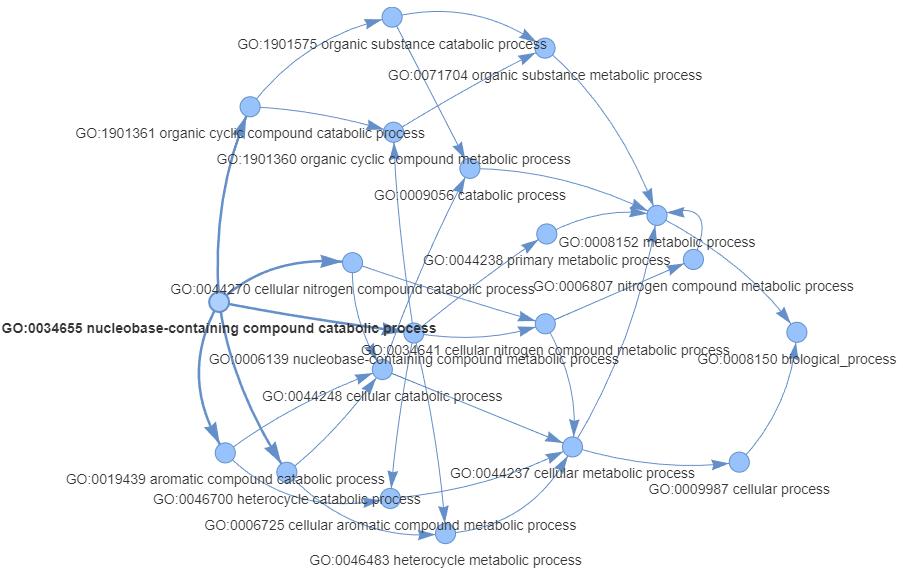

<p style=" font-size: 16px;">⚪ In the first graph, only the nodes are connected by relational ties between them, that is, which are located in <code>is_a</code>. But the second one shows a complete graph in which you can see how the connection will look with a non-peripheral relationship between all the nodes in the graph.</p> 

In [17]:
# Extract relevant information from the ontology
terms_data = []

for term_id in graph:
    term = graph.nodes[term_id]
    parents = list(networkx.DiGraph.predecessors(graph, term_id))
    children = list(networkx.DiGraph.successors(graph, term_id))
    
    term_data = {
        'id': term_id,
        'name': term['name'],
        'namespace': term['namespace'],
        'parents': parents,
        'children': children
    }
    terms_data.append(term_data)

# Create DataFrame
terms_df = pd.DataFrame(terms_data)

In [18]:
terms_df.head(20)

,id,name,namespace,parents,children
0,GO:0000001,mitochondrion inheritance,biological_process,[],"[GO:0048308, GO:0048311]"
1,GO:0000002,mitochondrial genome maintenance,biological_process,[GO:0032042],[GO:0007005]
2,GO:0000003,reproduction,biological_process,"[GO:0019953, GO:0019954, GO:0022414, GO:003250...",[GO:0008150]
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,[],[GO:0005385]
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,[],[GO:0005385]
5,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"[GO:0033164, GO:0052917]",[GO:0000030]
6,GO:0000010,trans-hexaprenyltranstransferase activity,molecular_function,[],[GO:0004659]
7,GO:0000011,vacuole inheritance,biological_process,[],"[GO:0007033, GO:0048308]"
8,GO:0000012,single strand break repair,biological_process,"[GO:1903516, GO:1903517, GO:1903518, GO:190382...",[GO:0006281]
9,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,molecular_function,"[GO:1990599, GO:1990601]",[GO:0004520]


<a id="2.2"></a>
## <b> 2.2 <span style='color:#F1A424'>|</span> Training sequences </b> 
***

<p style=" font-size: 16px;">⚪ <code>Training sequences</code>: <b>train_sequences.fasta</b> contains the protein sequences for the training dataset.</p>

<p style="font-size: 16px;">⚪ This files are in <a href="https://en.wikipedia.org/wiki/FASTA_format"><strong>FASTA format</strong></a>, a standard format for describing protein sequences. The proteins were all retrieved from the <a href="https://www.uniprot.org/"><strong>UniProt data set</strong></a> curated at the European Bioinformatics Institute.</p>

<p style="font-size: 16px;">⚪ The header contains the protein's UniProt accession ID and additional information about the protein. Most protein sequences were extracted from the Swiss-Prot database, but a subset of proteins that are not represented in Swiss-Prot were extracted from the TrEMBL database. In both cases, the sequences come from the 2022_05 release from 14-Dec-2022. More information can be found <a href="https://www.uniprot.org/help/uniprotkb_sections"><strong>here</strong></a>.</p>

<p style=" font-size: 16px;">⚪ The <code>train_sequences.fasta</code> file will indicate from which database the sequence originate. For example, <code>sp|P9WHI7|RECN_MYCT</code> in the FASTA header indicates the protein with UniProt ID <code>P9WHI7</code> and gene name <code>RECN_MYCT</code> was taken from Swiss-Prot (<code>sp</code>). Any sequences taken from TrEMBL will have <code>tr</code> in the header instead of <code>sp</code>. Swiss-Prot and TrEMBL are both parts of UniProtKB.</p>

<p style=" font-size: 16px;">⚪ This file contains only sequences for proteins with annotations in the dataset (labeled proteins). To obtain the full set of protein sequences for unlabeled proteins, the Swiss-Prot and TrEMBL databases can be found <a href="https://www.uniprot.org/help/downloads"><strong>here</strong></a>.</p>

<p style="font-size: 16px;">🔴 To read and analyze the protein sequences from the <b>train_sequences.fasta</b> file, we can use the <code>Biopython</code> package.</p> 

In [19]:
print("Sequence example:\n\n", next(iter(SeqIO.parse(CFG.train_seq_fasta_path, "fasta"))))

Sequence example:

 ID: P20536
Name: P20536
Description: P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosylase OS=Vaccinia virus (strain Copenhagen) OX=10249 GN=UNG PE=1 SV=1
Number of features: 0
Seq('MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLK...FIY')


>❔ Let's count the number of sequences.

In [20]:
# sequences = SeqIO.parse(CFG.train_seq_fasta_path, "fasta")
# Initialize empty lists to store sequence IDs and sequences
seq_ids = []
sequences = []

# Iterate over sequences in the FASTA file and extract IDs and sequences
for record in SeqIO.parse(CFG.train_seq_fasta_path, "fasta"):
    seq_ids.append(record.id)
    sequences.append(str(record.seq))

# Create a DataFrame from the lists
df = pd.DataFrame({"ID": seq_ids, "Sequence": sequences})
df.head(10)

,ID,Sequence
0,P20536,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...
1,O73864,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...
2,O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...
3,A0A0B4J1F4,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
4,P54366,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...
5,P33681,MGHTRRQGTSPSKCPYLNFFQLLVLAGLSHFCSGVIHVTKEVKEVA...
6,P77596,MTIEKIFTPQDDAFYAVITHAAGPQGALPLTPQMLMESPSGNLFGM...
7,Q16787,MAAAARPRGRALGPVLPPTPLLLLVLRVLPACGATARDPGAAAGLS...
8,Q59VP0,MLSKRLFPYSNLFPRSRKYKFIVYFIICLTIIISALGVYLYSIPIV...
9,P13508,MRVLLILLAFFAPIASQLMGGECGREGACSVNGKCYNGKLIETYWC...


In [21]:
sequences = SeqIO.parse(CFG.train_seq_fasta_path, "fasta")
num_sequences = sum([1 for seq in sequences])

print("Number of sequences:", num_sequences)

Number of sequences: 142246


>❔ Let's plot the length distribution of the protein sequences.

In [22]:
# get the length of each sequence
sequences = SeqIO.parse(CFG.train_seq_fasta_path, "fasta")
lengths = [len(seq) for seq in sequences]

fig = px.histogram(x=lengths, nbins=1000, color_discrete_sequence=['goldenrod'])
fig.update_layout(
    title={
        'text': "Distribution of protein sequence lengths",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Sequence length", yaxis_title="Count"
)

fig.show()

>❔ Let's check to what value 99% of the values are located.</p>

In [23]:
np.percentile(lengths, 99)

2718.5499999999884

<p style="font-size: 16px;">⚪ This also means that only <b>1%</b> of the data is present after the value <b>2817</b>.</p>

>❔ Let's calculate <b>the amino acid composition</b> of each protein sequence. Amino acid composition is the frequency distribution of amino acids in a protein sequence. It can provide valuable information about the protein's structure and function.

In [24]:
records = SeqIO.parse(CFG.train_seq_fasta_path, "fasta")

# create a list of all amino acids in the sequences
aa_list = [aa for record in records for aa in record.seq]

# count the frequency of each amino acid
aa_count = Counter(aa_list)

fig = px.bar(
    x=list(aa_count.values()), y=list(aa_count.keys()),
    color_discrete_sequence=['darkslateblue'],
    orientation='h', height=700
)
fig.update_layout(
    title={
        'text': "Amino Acid Composition",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Frequency", yaxis_title="Amino Acid"
)
fig.show()

<p style="font-size: 16px;">⚪ Here are a few observations that can be made from the obtained frequency values:</p>

* <p style="font-size: 16px;">The most common amino acids in this dataset are leucine (L), serine (S), alanine (A), and glycine (G). These amino acids are known to be abundant in proteins and play important roles in protein structure and function.</p>
* <p style="font-size: 16px;">The least common amino acids in this dataset are cysteine (C), methionine (M), tryptophan (W), and histidine (H). These amino acids are typically less abundant in proteins, but they can be important for specific functions, such as catalysis, metal binding, or protein-protein interactions.</p>
* <p style="font-size: 16px;">The presence of the amino acid selenocysteine (U) in the dataset suggests that some of the proteins may be selenoproteins, which contain selenium in the form of selenocysteine instead of cysteine.</p>
* <p style="font-size: 16px;">The presence of ambiguous amino acids (X, B, Z) and rare amino acids (O, U) in the dataset suggests that some of the sequences may be incomplete or contain errors.</p>

<a id="2.3"></a>
## <b> 2.3 <span style='color:#F1A424'>|</span> Labels </b> 
***

<p style="font-size: 16px;">⚪ <code>Labels</code>: <b>train_terms.tsv</b> contains the list of annotated terms (ground truth) for the proteins in train_sequences.fasta.</p> 

* <p style=" font-size: 16px;">The first column indicates the protein's UniProt accession ID.</p>
* <p style="font-size: 16px;">The second is the GO term ID.</p>
* <p style="font-size: 16px;">The third indicates in which ontology the term appears (BPO, CCO or MFO). BPO, CCO, and MFO are abbreviations for different categories of gene ontology terms. <code>BPO</code>: Biological Process Ontology, which describes biological processes, functions, and pathways. <code>CCO</code>: Cellular Component Ontology, which describes the components of a cell or its extracellular environment. <code>MFO</code>: Molecular Function Ontology, which describes the biochemical activities or capabilities of proteins and other molecules. These categories are used in gene ontology to classify genes and gene products based on their biological roles and functions. By using these categories, researchers can better understand the functions and interactions of different genes and gene products within a biological system.</p>

<p style=" font-size: 16px;">⚪ Load the train terms dataframe.</p> 

In [25]:
train_terms_df = pd.read_csv(CFG.train_terms_path, sep="\t")

>❔ Let's look how's data looks like.

In [26]:
train_terms_df.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


>❔ Display main information about dataframe columns.

In [27]:
train_terms_df.describe()

,EntryID,term,aspect
count,5363863,5363863,5363863
unique,142246,31466,3
top,Q02248,GO:0005575,BPO
freq,815,92912,3497732


>❔ Now let's plot pie distribution of aspect values.

In [28]:
aspect_counts = train_terms_df.aspect.value_counts()

fig = px.pie(values=aspect_counts.values, names=aspect_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of aspect values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

<a id="2.4"></a>
## <b> 2.4 <span style='color:#F1A424'>|</span> Taxonomy </b> 
***

<p style="font-size: 16px;">⚪ <code>Taxonomy</code>: <b>train_taxonomy.tsv</b> contains the list of proteins and the species to which they belong, represented by a "taxonomic identifier" (taxon ID) number. The first column is the protein UniProt accession ID and the second is the taxon ID. More information about taxonomies can he found <a href="https://www.uniprot.org/help/taxonomic_identifier"><strong>here</strong></a>.</p>

<p style="font-size: 16px;">⚪ Load the train taxonomy dataframe.</p>

In [29]:
train_taxonomy_df = pd.read_csv(CFG.train_taxonomy_path, sep="\t")

>❔ Let's look how's data looks like.

In [30]:
train_taxonomy_df.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


>❔ Display dataframe length.

In [31]:
len(train_taxonomy_df)

142246

In [32]:
#TODO: Join train_terms_df.EntryID on train_taxonomy_df.EntryID

<a id="2.5"></a>
## <b> 2.5 <span style='color:#F1A424'>|</span> Information accretion</b> 

<p style=" font-size: 16px;">⚪ <code>Information accretion</code>: <b>IA.txt</b> contains the information accretion (weights) for each GO term. These weights are used to compute weighted precision and recall, as described in the Evaluation section of the competition.</p>

In [33]:
limit = 10

with open(CFG.train_ia_path) as f:
    ia_weights = [x.replace("\n", "").split("\t") for x in f.readlines()]

ia_weights[:limit]

[['GO:0000001', '0.0'],
 ['GO:0000002', '3.10383581098454'],
 ['GO:0000003', '3.4394041159928754'],
 ['GO:0000011', '0.056583528366367424'],
 ['GO:0000012', '6.400377192572712'],
 ['GO:0000017', '0.5145731728297583'],
 ['GO:0000018', '2.154071050241475'],
 ['GO:0000019', '3.023846741954368'],
 ['GO:0000022', '0.0'],
 ['GO:0000023', '3.415037499278844']]

In [34]:
# (⁠ ⁠ꈍ⁠ᴗ⁠ꈍ⁠) WORK STILL IN PROGRESS